### Plot the magnetization of a halbach array, and add the magnetization of shimming sphere

In [320]:
import numba


def mSymFunc(m,factors=1, flipDipolexy=False, symmetryAngle=np.pi / 3):
   # phiSym = phi0 + (-symmetryAngle) * factors  # symmetryAngle to rotate the dipole position by
   deltaTheta = -symmetryAngle * factors  # symmetryAngle to rotate the dipole direction vector by
   mSym = m.copy()
   MRot = np.array([[np.cos(deltaTheta), -np.sin(deltaTheta)], [np.sin(deltaTheta), np.cos(deltaTheta)]])
   mSym = MRot @ mSym
   if flipDipolexy == True:
       mSym = -mSym
   print(m,mSym)
   return mSym

[ 0.92369335 -0.3831326 ] [ 0.92369335 -0.3831326 ]
[ 0.92369335 -0.3831326 ] [-0.13004411  0.99150821]
[ 0.92369335 -0.3831326 ] [-0.79364924 -0.60837561]


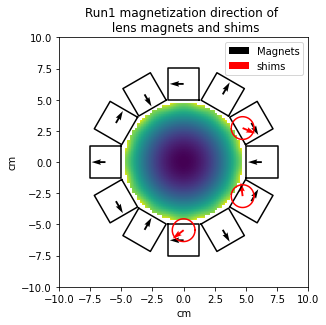

In [322]:
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Polygon,Point
from shapely.affinity import rotate
from HalbachLensClass import Layer

rp=(.05,)
width=.0254

thetaArr = np.linspace(0, 2 * np.pi, 12, endpoint=False)  # location of 12 magnets
thetaArr=thetaArr.reshape(-1,len(rp)).T
phiArr = np.pi + np.arange(0, 12) * 2 * np.pi / 3 #direction of magnetization
phiArr=phiArr.reshape(-1,len(rp)).T
quiverData=[]
for r,r_phi,r_theta in zip(rp,phiArr,thetaArr):
    for phi,theta in zip(r_phi,r_theta):
        x,y=(r+width/2)*np.cos(theta)*1e2,(r+width/2)*np.sin(theta)*1e2
        quiverData.append([x,y,np.cos(phi),np.sin(phi)])
quiverData=np.asarray(quiverData)

squareCoords=np.asarray([(rp[0],-width/2),(rp[0]+width,-width/2),(rp[0]+width,width/2),(rp[0],width/2)])*1e2
squareOriginal=Polygon(squareCoords)
angleArr=np.linspace(0,np.pi*2,13)[:-1]
for angle in angleArr[:]:
    square=rotate(squareOriginal,angle,origin=(0,0),use_radians=True)
    plt.plot(*square.exterior.xy,c='black')





plt.quiver(*quiverData.T,label='Magnets')
rShim=.0546
phi0=np.pi/6
radius=.911
psi0=5.89
point0=Point([1e2*rShim,0])
phiArr=phi0+np.linspace(0.0,2*np.pi,7)[1:]
phiArr=np.flip(phiArr)

assert abs(abs(phiArr[1]-phiArr[0])-np.pi/3)<1e-6
psi=psi0
m=np.asarray([np.cos(psi),np.sin(psi)])
quiverData=[]
i=0
booList=[False,True]*5
for phi in phiArr[:3]:
    point=rotate(point0,phi,origin=(0.0,0.0),use_radians=True)
    plt.plot(*point.buffer(radius).exterior.xy,c='r')
    x,y=1e2*rShim*np.cos(phi),1e2*rShim*np.sin(phi)
    mSym=mSymFunc(m,factors=i,flipDipolexy=booList[i])
    quiverData.append([x,y,*mSym])
    i+=1
quiverData=np.asarray(quiverData)
plt.quiver(*quiverData.T,color='r',label='shims')# plt.quiver(quiverData[:,0],quiverData[:,1],quiverData[:,2],quiverData[:,3],color='r',label='shims')

layer=Layer(0.0,width,.5,rp)
xArr=np.linspace(-rp[0],rp[0],50)
coords=np.asarray(np.meshgrid(xArr,xArr,0.0)).T.reshape(-1,3)
BVec=layer.B(coords)
B=np.linalg.norm(BVec,axis=1)
B[np.linalg.norm(coords,axis=1)>rp[0]*.99]=np.nan
B=B.reshape(len(xArr),len(xArr))
plt.imshow(B,extent=[min(xArr)*100.0,max(xArr)*100.0]*2)
# BxGrid=BVec[:,0].reshape(len(xArr),len(xArr))
# ByGrid=BVec[:,1].reshape(len(xArr),len(xArr))
# plt.streamplot(xArr*1e2,xArr*1e2,BxGrid,ByGrid,density=.8)

plt.gca().set_aspect('equal')
plt.tight_layout()
plt.legend()
plt.xlabel('cm')
plt.ylabel('cm')
plt.title('Run1 magnetization direction of \n lens magnets and shims')
plt.xlim([-10,10])
plt.ylim([-10,10])
plt.show()

In [256]:
booList

[True, False, True, False, True, False, True, False, True, False]

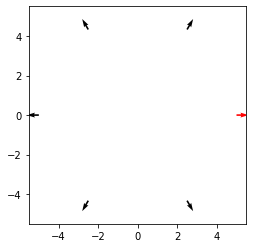

In [70]:
import matplotlib.pyplot as plt
import numpy as np
phi0=0*np.pi/2
r=5.0
theta0=0*np.pi/2
m=np.asarray([np.cos(phi0),np.sin(phi0)])
x,y=r*np.cos(theta0),r*np.sin(theta0)
phiArr=np.arange(0, 6) * 4 * np.pi / 3
def B_Symmetry(r,rotations,rotationAngle=np.pi/3):
    xSym,ySym=r*np.cos(rotationAngle*rotations),r*np.sin(rotationAngle*rotations)
    if rotations%2==1:
        mu = np.tan(rotations*rotationAngle/2)
        M_uc = np.asarray([[1 - mu ** 2, 2 * mu], [2 * mu, mu ** 2 - 1]]) * 1 / (1 + mu ** 2)  # reflection matrix
        mSym=M_uc@m
    else:
        M_Angle=rotationAngle*rotations
        MRot = np.array([[np.cos(M_Angle), -np.sin(M_Angle)], [np.sin(M_Angle), np.cos(M_Angle)]])
        mSym=MRot@m
    # if rotations%2==0:
    #     mSym=-mSym
    # mSym=np.asarray([np.cos(phi0+phiArr[rotations]),np.sin(phi0+phiArr[rotations])])
    plt.quiver(xSym,ySym,*mSym)
B_Symmetry(r,1)
B_Symmetry(r,2)
B_Symmetry(r,3)
B_Symmetry(r,4)
B_Symmetry(r,5)

plt.quiver(x,y,*m,color='r')
plt.gca().set_aspect('equal')
# plt.tight_layout()
plt.xlim([-1.1*r,1.1*r])
plt.ylim([-1.1*r,1.1*r])
plt.show()



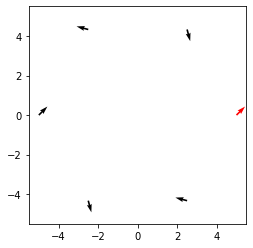

In [84]:
import matplotlib.pyplot as plt
import numpy as np
phi0=.5*np.pi/2
r=5.0
theta0=0*np.pi/2
m=np.asarray([np.cos(phi0),np.sin(phi0)])
x,y=r*np.cos(theta0),r*np.sin(theta0)
def B_Symmetry(r,rotations,rotationAngle=np.pi/3):
    xSym,ySym=r*np.cos(rotationAngle*rotations),r*np.sin(rotationAngle*rotations)
    M_Angle=rotationAngle*rotations
    MRot = np.array([[np.cos(M_Angle), -np.sin(M_Angle)], [np.sin(M_Angle), np.cos(M_Angle)]])
    mSym=MRot@m
    mSym*=(-1)**rotations
    # if rotations%2==0:
    #     mSym=-mSym
    # mSym=np.asarray([np.cos(phi0+phiArr[rotations]),np.sin(phi0+phiArr[rotations])])
    plt.quiver(xSym,ySym,*mSym)
B_Symmetry(r,1)
B_Symmetry(r,2)
B_Symmetry(r,3)
B_Symmetry(r,4)
B_Symmetry(r,5)

plt.quiver(x,y,*m,color='r')
plt.gca().set_aspect('equal')
# plt.tight_layout()
plt.xlim([-1.1*r,1.1*r])
plt.ylim([-1.1*r,1.1*r])
plt.show()



In [8]:
import numpy as np

a=np.array([0.22335083, 0.05468504, 0.01778291, 1.86398975, 5.89642321])
b=np.array([0.22336635, 0.05398954, 0.01994955, 2.174386  , 5.1246072 ])
c=np.array([0.22336904, 0.05486956, 0.01967456, 1.16595304, 4.66104557])
d=np.array([0.22232782 ,0.05411236 ,0.01467107 ,1.69968186 ,5.40909307])
e=np.array([0.2228413  ,0.05462561 ,0.01132046 ,1.28740702 ,5.31414559])
arr=np.column_stack((a,b,c,d,e))
np.std(arr,axis=1),np.mean(arr,axis=1)

(array([4.14115074e-04, 3.42908512e-04, 3.27518627e-03, 3.71033510e-01,
        4.01261604e-01]),
 array([0.22305107, 0.05445642, 0.01667971, 1.63828353, 5.28106293]))

In [11]:
#locked phi,locked theta, variable radius
a=np.array([0.2425    , 0.06891085, 0.02262274, 3.05662444, 0.02194268,
            0.06575895, 0.04839916, 5.17701814, 0.0254,.08078    ])
e=np.zeros(len(a))*np.nan
e[0]=.23
e[-1]=1.0

rowLabels=['L', 'r', 'deltaZ','psi','radius','r', 'deltaZ','psi','radius','cost']
colLabels=['param,SI','run1','baseline lens']
cellText=[]




cellText=[rowLabels,arrToStr(a),arrToStr(e)]
cellText=list(zip(*cellText))
fig, ax = plt.subplots()
ax.set_axis_off()
ax.table(cellText=cellText,cellLoc ='center',loc ='upper left',colLabels=colLabels)
plt.savefig('poop',dpi=100)
plt.show()

5.235987755982989

[0.0, 0.0]


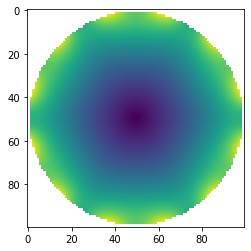

In [25]:
from geneticLensClass import GeneticLens
import numpy as np
import matplotlib.pyplot as plt

rp=.05
width=.0254
length=.0254

DNAList=[]
phaseList=[0.0,0*np.pi/24]
print(phaseList)
for phase in phaseList:
    dict={'component':'layer','length':length,'width':width,'rp':rp,'phase':phase}
    DNAList.append(dict)
lens=GeneticLens(DNAList)
xArr=np.linspace(-rp*.9,rp*.9,100)
coords=np.asarray(np.meshgrid(xArr,xArr,0.0)).T.reshape(-1,3)
vals=np.linalg.norm(lens.BNorm_Gradient(coords),axis=1)
vals[np.linalg.norm(coords[:,:2],axis=1)>xArr.max()]=np.nan
image=vals.reshape(len(xArr),len(xArr))
plt.imshow(image)
plt.show()

138495.08612143216


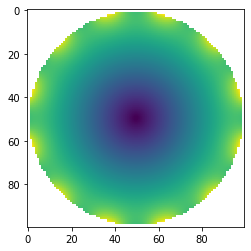

138423.34798352577


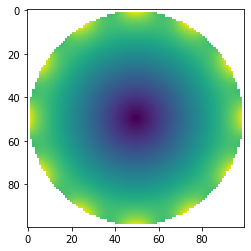

128008.7705542105


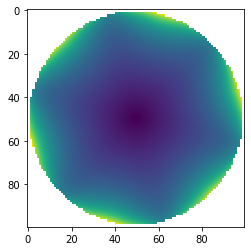

In [48]:
from geneticLensClass import GeneticLens
import numpy as np
import matplotlib.pyplot as plt

rp=.05
width=.0254
length=.0254*10
def plot_Field(phaseList):
    DNAList=[]
    for phase in phaseList:
        dict={'component':'layer','length':length,'width':width,'rp':rp,'phase':phase}
        DNAList.append(dict)
    lens=GeneticLens(DNAList)
    xArr=np.linspace(-rp*.9,rp*.9,100)
    coords=np.asarray(np.meshgrid(xArr,xArr,0.0)).T.reshape(-1,3)
    vals=np.linalg.norm(lens.BNorm_Gradient(coords),axis=1)
    vals[np.linalg.norm(coords[:,:2],axis=1)>xArr.max()]=np.nan
    image=vals.reshape(len(xArr),len(xArr))
    print(np.nansum(image))
    plt.imshow(image)
    plt.show()
plot_Field([0.0]*2)
plot_Field([np.pi/12]*2)
plot_Field([0.0,np.pi/6])

In [12]:
import numpy as np
import matplotlib.pyplot as plt
data=np.loadtxt("data")

In [13]:
data

array([[ 5.00000000e+00,             nan,             nan,
                    nan],
       [ 6.00000000e+00,             nan,             nan,
                    nan],
       [ 7.00000000e+00,             nan,             nan,
                    nan],
       [ 8.00000000e+00,             nan,             nan,
                    nan],
       [ 9.00000000e+00,  9.64950040e-01,  1.00508048e+00,
         7.37933564e-12],
       [ 1.00000000e+01,  9.64860882e-01,  1.00497261e+00,
        -3.87047873e-12],
       [ 1.10000000e+01,  9.64883935e-01,  1.00512460e+00,
         3.89087191e-12],
       [ 1.20000000e+01,  9.64972302e-01,  1.00507125e+00,
         1.69545225e-11],
       [ 1.30000000e+01,  9.64969125e-01,  1.00509799e+00,
        -2.85799591e-12],
       [ 1.40000000e+01,  9.64954263e-01,  1.00503565e+00,
         2.40735088e-12],
       [ 1.50000000e+01,  9.64967604e-01,  1.00507673e+00,
        -8.77421807e-12],
       [ 1.60000000e+01,  9.65002542e-01,  1.00504317e+00,
      

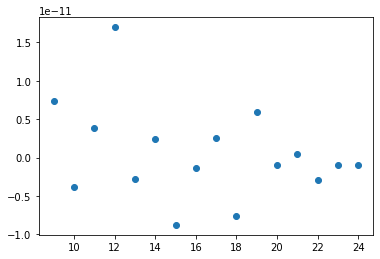

In [16]:
plt.scatter(data[:,0],data[:,3])
plt.show()

In [18]:
from typing import Sequence
isinstance([1,],Sequence)

True

In [27]:
a=[1,2,3]
b=(i**2 for i in a)

In [88]:
from numba.experimental import jitclass
from numba import float64,int64
spec=[
    ('data',float64[:]),
    ('a',float64),
    ('b',float64)

]
@jitclass(spec)
class helper:
    def __init__(self,data,a,b):
        self.data=data
        self.a=a
        self.b=b
    def compute(self,x):
        return x+self.a+self.b+np.mean(self.data)
    def get_Args(self):
        return self.data,self.a,self.b
    def __getstate__(self):
        print('here')
# class Foo:
#     def __init__(self,a,b=2.):
#         self.a=a
#         self.b=b
#         self.helperArgs=None
#         self.helper=helper(np.random.random_sample(10),self.a,self.b)
#     def math(self,x):
#         return self.helper.compute(x)
#     def __getstate__(self):
#         # self.helperArgs=self.helper.get_Args()
#         # self.helper=None
#         return self.__dict__
#     def __setstate__(self,d):
#         self.__dict__=d
#         self.helper=helper(*self.helperArgs)

# import pickle
help=helper(np.random.random_sample(10),1.0,1.0)
# f = Foo(9.0)
# print(f.math(1.0))
# f_data = pickle.dumps(help)
# f_new = pickle.loads(f_data)
# print(f_new.math(1.0))


{'a': 1.0,
 'b': 2.0,
 'helperArgs': None,
 'helper': <numba.experimental.jitclass.boxing.helper at 0x14b79f070>}

In [26]:
sum(b)

14